In [1]:
!conda env list

# conda environments:
#
base                     /opt/anaconda3
ers-transit           *  /opt/anaconda3/envs/ers-transit



In [3]:
import exoplanet

In [4]:
exoplanet.utils.docs_setup()

In [5]:
print(f"exoplanet.__version__ = '{exoplanet.__version__}'")

exoplanet.__version__ = '0.5.1'


In [7]:
import numpy as np
import lightkurve as lk
from astropy.io import fits
from collections import OrderedDict
import matplotlib.pyplot as plt

In [10]:
import pymc3 as pm
import pymc3_ext as pmx
import exoplanet as xo
import aesara_theano_fallback.tensor as tt
from functools import partial

In [11]:
from celerite2.theano import terms, GaussianProcess

In [12]:
# Period and reference transit time from the literature for initialization
lit_period = 4.887803076
lit_t0 = 124.8130808

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


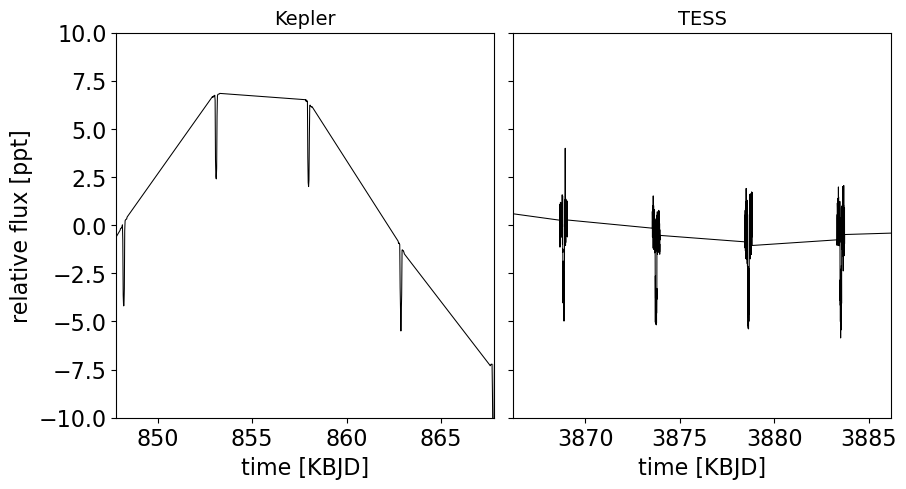

In [13]:
def transit_mask(t):
    return (
        np.abs((t - lit_t0 + 0.5 * lit_period) % lit_period - 0.5 * lit_period)
        < 0.2
    )


kepler_lcfs = lk.search_lightcurve(
    "HAT-P-11", mission="Kepler", cadence="long"
).download_all(flux_column="pdcsap_flux")
kepler_lc = kepler_lcfs.stitch().remove_nans()

# For the purposes of this example, let's only clip out data near the transits
m = transit_mask(kepler_lc.time.value)
kepler_t = np.ascontiguousarray(kepler_lc.time.value[m], dtype=np.float64)
kepler_y = np.ascontiguousarray(
    1e3 * (kepler_lc.flux[m] - 1), dtype=np.float64
)
kepler_yerr = np.ascontiguousarray(
    1e3 * kepler_lc.flux_err[m], dtype=np.float64
)

with fits.open(kepler_lcfs[0].filename) as hdu:
    hdr = hdu[1].header
kepler_texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
kepler_texp /= 60.0 * 60.0 * 24.0

tess_lcfs = lk.search_lightcurve(
    "HAT-P-11", mission="TESS", author="SPOC"
).download_all(flux_column="pdcsap_flux")
tess_lc = tess_lcfs.stitch().remove_nans()

# For the purposes of this example, let's only clip out data near the transits
t = tess_lc.time.value + 2457000 - 2454833
m = transit_mask(t)
tess_t = np.ascontiguousarray(t[m], dtype=np.float64)
tess_y = np.ascontiguousarray(1e3 * (tess_lc.flux[m] - 1), dtype=np.float64)
tess_yerr = np.ascontiguousarray(1e3 * tess_lc.flux_err[m], dtype=np.float64)

with fits.open(tess_lcfs[0].filename) as hdu:
    hdr = hdu[1].header
tess_texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
tess_texp /= 60.0 * 60.0 * 24.0

datasets = OrderedDict(
    [
        ("Kepler", [kepler_t, kepler_y, kepler_yerr, kepler_texp]),
        ("TESS", [tess_t, tess_y, tess_yerr, tess_texp]),
    ]
)

fig, axes = plt.subplots(1, len(datasets), sharey=True, figsize=(10, 5))

for i, (name, (t, y, _, _)) in enumerate(datasets.items()):
    ax = axes[i]
    ax.plot(t, y, "k", lw=0.75, label=name)
    ax.set_xlabel("time [KBJD]")
    ax.set_title(name, fontsize=14)

    x_mid = 0.5 * (t.min() + t.max())
    ax.set_xlim(x_mid - 10, x_mid + 10)
axes[0].set_ylim(-10, 10)
fig.subplots_adjust(wspace=0.05)
_ = axes[0].set_ylabel("relative flux [ppt]")

In [14]:
# Find a reference transit time near the middle of the observations to avoid
# strong covariances between period and t0
x_min = min(np.min(x) for x, _, _, _ in datasets.values())
x_max = max(np.max(x) for x, _, _, _ in datasets.values())
x_mid = 0.5 * (x_min + x_max)
t0_ref = lit_t0 + lit_period * np.round((x_mid - lit_t0) / lit_period)

In [15]:
# Do several rounds of sigma clipping
for i in range(10):
    with pm.Model() as model:

        # Shared orbital parameters
        log_period = pm.Normal("log_period", mu=np.log(lit_period), sigma=1.0)
        period = pm.Deterministic("period", tt.exp(log_period))
        t0 = pm.Normal("t0", mu=t0_ref, sigma=1.0)
        log_dur = pm.Normal("log_dur", mu=np.log(0.1), sigma=10.0)
        dur = pm.Deterministic("dur", tt.exp(log_dur))
        b = pmx.UnitUniform("b")
        ld_arg = 1 - tt.sqrt(1 - b ** 2)
        orbit = xo.orbits.KeplerianOrbit(
            period=period, duration=dur, t0=t0, b=b
        )
        

        # We'll also say that the timescale of the GP will be shared
        rho_gp = pm.InverseGamma(
            "rho_gp",
            testval=2.0,
            **pmx.estimate_inverse_gamma_parameters(1.0, 5.0),
        )

        # Loop over the instruments
        parameters = dict()
        lc_models = dict()
        gp_preds = dict()
        gp_preds_with_mean = dict()
        for n, (name, (x, y, yerr, texp)) in enumerate(datasets.items()):

            # We define the per-instrument parameters in a submodel so that we
            # don't have to prefix the names manually
            with pm.Model(name=name, model=model):
                # The flux zero point
                mean = pm.Normal("mean", mu=0.0, sigma=10.0)

                # The limb darkening
                u = xo.QuadLimbDark("u")
                star = xo.LimbDarkLightCurve(u)

                # The radius ratio
                log_approx_depth = pm.Normal(
                    "log_approx_depth", mu=np.log(4e-3), sigma=10
                )
                ld = 1 - u[0] * ld_arg - u[1] * ld_arg ** 2
                ror = pm.Deterministic(
                    "ror", tt.exp(0.5 * log_approx_depth) / tt.sqrt(ld)
                )

                # Noise parameters
                med_yerr = np.median(yerr)
                std = np.std(y)
                sigma = pm.InverseGamma(
                    "sigma",
                    testval=med_yerr,
                    **pmx.estimate_inverse_gamma_parameters(
                        med_yerr, 0.5 * std
                    ),
                )
                sigma_gp = pm.InverseGamma(
                    "sigma_gp",
                    testval=0.5 * std,
                    **pmx.estimate_inverse_gamma_parameters(
                        med_yerr, 0.5 * std
                    ),
                )

                # Keep track of the parameters for optimization
                parameters[name] = [mean, u, log_approx_depth]
                parameters[f"{name}_noise"] = [sigma, sigma_gp]
                
                #print(parameters[mean])
                #break

            # The light curve model
            def lc_model(mean, star, ror, texp, t):
                return mean + 1e3 * tt.sum(
                    star.get_light_curve(orbit=orbit, r=ror, t=t, texp=texp),
                    axis=-1,
                )

            lc_model = partial(lc_model, mean, star, ror, texp)
            lc_models[name] = lc_model

            # The Gaussian Process noise model
            kernel = terms.SHOTerm(sigma=sigma_gp, rho=rho_gp, Q=1.0 / 3)
            gp = GaussianProcess(
                kernel, t=x, diag=yerr ** 2 + sigma ** 2, mean=lc_model
            )
            gp.marginal(f"{name}_obs", observed=y)
            gp_preds[name] = gp.predict(y, include_mean=False)
            gp_preds_with_mean[name] = gp_preds[name] + gp.mean_value

        # Optimize the model
        map_soln = model.test_point
        for name in datasets:
            map_soln = pmx.optimize(map_soln, parameters[name])
        for name in datasets:
            map_soln = pmx.optimize(map_soln, parameters[f"{name}_noise"])
            map_soln = pmx.optimize(map_soln, parameters[name] + [log_dur, b])
        map_soln = pmx.optimize(map_soln)

        # Do some sigma clipping
        num = dict((name, len(datasets[name][0])) for name in datasets)
        clipped = dict()
        masks = dict()
        for name in datasets:
            mdl = pmx.eval_in_model(gp_preds_with_mean[name], map_soln)
            resid = datasets[name][1] - mdl
            sigma = np.sqrt(np.median((resid - np.median(resid)) ** 2))
            masks[name] = np.abs(resid - np.median(resid)) < 7 * sigma
            clipped[name] = num[name] - masks[name].sum()
            print(f"Sigma clipped {clipped[name]} {name} light curve points")

        if all(c < 10 for c in clipped.values()):
            break

        else:
            for name in datasets:
                datasets[name][0] = datasets[name][0][masks[name]]
                datasets[name][1] = datasets[name][1][masks[name]]
                datasets[name][2] = datasets[name][2][masks[name]]

optimizing logp for variables: [Kepler_log_approx_depth, Kepler_u, Kepler_mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -36929.236803205036 -> -7691.628762472666
optimizing logp for variables: [TESS_log_approx_depth, TESS_u, TESS_mean]


message: Optimization terminated successfully.
logp: -7691.628762472666 -> -7487.191191801795
optimizing logp for variables: [Kepler_sigma_gp, Kepler_sigma]


message: Optimization terminated successfully.
logp: -7487.191191801795 -> -2129.5725013977067
optimizing logp for variables: [b, log_dur, Kepler_log_approx_depth, Kepler_u, Kepler_mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -2129.5725013976953 -> -1214.4800755921462
optimizing logp for variables: [TESS_sigma_gp, TESS_sigma]


message: Optimization terminated successfully.
logp: -1214.4800755921426 -> -1183.3252050269932
optimizing logp for variables: [b, log_dur, TESS_log_approx_depth, TESS_u, TESS_mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -1183.3252050269969 -> -1129.3497088793317
optimizing logp for variables: [TESS_sigma_gp, TESS_sigma, TESS_log_approx_depth, TESS_u, TESS_mean, Kepler_sigma_gp, Kepler_sigma, Kepler_log_approx_depth, Kepler_u, Kepler_mean, rho_gp, b, log_dur, t0, log_period]


message: Desired error not necessarily achieved due to precision loss.
logp: -1129.3497088793317 -> 450.8327422402963


Sigma clipped 85 Kepler light curve points
Sigma clipped 5 TESS light curve points


optimizing logp for variables: [Kepler_log_approx_depth, Kepler_u, Kepler_mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -33780.41785260415 -> -4579.641145820008
optimizing logp for variables: [TESS_log_approx_depth, TESS_u, TESS_mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -4579.641145820008 -> -4371.468963215762
optimizing logp for variables: [Kepler_sigma_gp, Kepler_sigma]


message: Optimization terminated successfully.
logp: -4371.468963215762 -> -1578.875897647806
optimizing logp for variables: [b, log_dur, Kepler_log_approx_depth, Kepler_u, Kepler_mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -1578.875897647804 -> -444.35797449685606
optimizing logp for variables: [TESS_sigma_gp, TESS_sigma]


message: Optimization terminated successfully.
logp: -444.3579744968538 -> -400.47645867748315
optimizing logp for variables: [b, log_dur, TESS_log_approx_depth, TESS_u, TESS_mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -400.47645867748497 -> -344.0779967283497
optimizing logp for variables: [TESS_sigma_gp, TESS_sigma, TESS_log_approx_depth, TESS_u, TESS_mean, Kepler_sigma_gp, Kepler_sigma, Kepler_log_approx_depth, Kepler_u, Kepler_mean, rho_gp, b, log_dur, t0, log_period]


message: Desired error not necessarily achieved due to precision loss.
logp: -344.0779967283497 -> 1666.2323128897215


Sigma clipped 25 Kepler light curve points
Sigma clipped 0 TESS light curve points


optimizing logp for variables: [Kepler_log_approx_depth, Kepler_u, Kepler_mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -33497.0890331396 -> -4296.353798782849
optimizing logp for variables: [TESS_log_approx_depth, TESS_u, TESS_mean]


message: Optimization terminated successfully.
logp: -4296.353798782849 -> -4088.181616178609
optimizing logp for variables: [Kepler_sigma_gp, Kepler_sigma]


message: Optimization terminated successfully.
logp: -4088.181616178609 -> -1533.051892128002
optimizing logp for variables: [b, log_dur, Kepler_log_approx_depth, Kepler_u, Kepler_mean]


message: Optimization terminated successfully.
logp: -1533.0518921280084 -> -366.5920785642461
optimizing logp for variables: [TESS_sigma_gp, TESS_sigma]


message: Optimization terminated successfully.
logp: -366.59207856422836 -> -322.34727682792345
optimizing logp for variables: [b, log_dur, TESS_log_approx_depth, TESS_u, TESS_mean]


message: Optimization terminated successfully.
logp: -322.34727682794164 -> -268.196236148196
optimizing logp for variables: [TESS_sigma_gp, TESS_sigma, TESS_log_approx_depth, TESS_u, TESS_mean, Kepler_sigma_gp, Kepler_sigma, Kepler_log_approx_depth, Kepler_u, Kepler_mean, rho_gp, b, log_dur, t0, log_period]


message: Desired error not necessarily achieved due to precision loss.
logp: -268.196236148196 -> 1851.8496467594196


Sigma clipped 7 Kepler light curve points
Sigma clipped 0 TESS light curve points


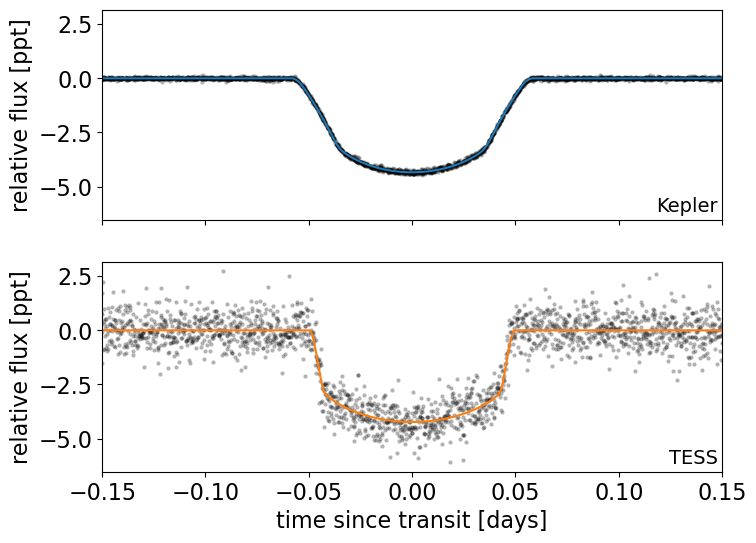

In [16]:
dt = np.linspace(-0.2, 0.2, 500)

with model:
    trends = pmx.eval_in_model([gp_preds[k] for k in datasets], map_soln)
    phase_curves = pmx.eval_in_model(
        [lc_models[k](t0 + dt) for k in datasets], map_soln
    )

fig, axes = plt.subplots(2, sharex=True, sharey=True, figsize=(8, 6))

for n, name in enumerate(datasets):
    ax = axes[n]

    x, y = datasets[name][:2]

    period = map_soln["period"]
    folded = (x - map_soln["t0"] + 0.5 * period) % period - 0.5 * period
    m = np.abs(folded) < 0.2
    ax.plot(
        folded[m],
        (y - trends[n] - map_soln[f"{name}_mean"])[m],
        ".k",
        alpha=0.3,
        mec="none",
    )
    ax.plot(
        dt, phase_curves[n] - map_soln[f"{name}_mean"], f"C{n}", label=name
    )
    ax.annotate(
        name,
        xy=(1, 0),
        xycoords="axes fraction",
        va="bottom",
        ha="right",
        xytext=(-3, 3),
        textcoords="offset points",
        fontsize=14,
    )

axes[-1].set_xlim(-0.15, 0.15)
axes[-1].set_xlabel("time since transit [days]")
for ax in axes:
    ax.set_ylabel("relative flux [ppt]")

In [17]:
import platform

with model:
    trace = pmx.sample(
        tune=1500,
        draws=1500,
        start=map_soln,
        # Parallel sampling runs poorly or crashes on macos
        cores=1 if platform.system() == "Darwin" else 2,
        chains=2,
        target_accept=0.95,
        return_inferencedata=True,
        random_seed=[11, 9],
    )

Sequential sampling (2 chains in 1 job)
NUTS: [TESS_sigma_gp, TESS_sigma, TESS_log_approx_depth, TESS_u, TESS_mean, Kepler_sigma_gp, Kepler_sigma, Kepler_log_approx_depth, Kepler_u, Kepler_mean, rho_gp, b, log_dur, t0, log_period]


Sampling 2 chains for 1_500 tune and 1_500 draw iterations (3_000 + 3_000 draws total) took 1818 seconds.


In [18]:
import arviz as az

az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log_period,1.587,0.000,1.587,1.587,0.000,0.000,3393.0,2395.0,1.0
t0,2011.505,0.000,2011.505,2011.505,0.000,0.000,3165.0,2289.0,1.0
log_dur,-2.388,0.002,-2.392,-2.384,0.000,0.000,917.0,1505.0,1.0
Kepler_mean,-0.441,0.538,-1.417,0.582,0.009,0.008,3223.0,2211.0,1.0
Kepler_log_approx_depth,-5.684,0.003,-5.689,-5.678,0.000,0.000,1957.0,1861.0,1.0
TESS_mean,0.266,0.410,-0.542,0.984,0.008,0.007,2752.0,1841.0,1.0
TESS_log_approx_depth,-5.669,0.013,-5.694,-5.646,0.000,0.000,2237.0,2092.0,1.0
period,4.888,0.000,4.888,4.888,0.000,0.000,3393.0,2395.0,1.0
dur,0.092,0.000,0.091,0.092,0.000,0.000,917.0,1505.0,1.0
b,0.392,0.059,0.275,0.495,0.002,0.001,934.0,675.0,1.0


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


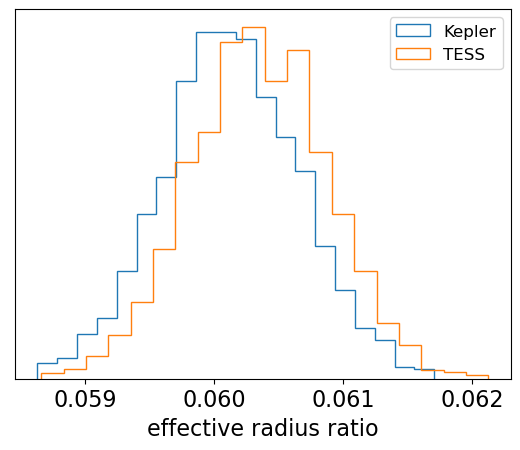

In [19]:
plt.hist(
    trace.posterior["Kepler_ror"].values.flatten(),
    20,
    density=True,
    histtype="step",
    label="Kepler",
)
plt.hist(
    trace.posterior["TESS_ror"].values.flatten(),
    20,
    density=True,
    histtype="step",
    label="TESS",
)
plt.yticks([])
plt.xlabel("effective radius ratio")
_ = plt.legend(fontsize=12)

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.


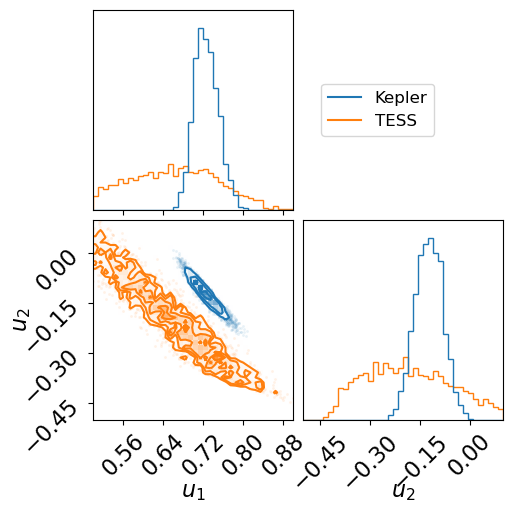

In [21]:
import corner

fig = corner.corner(
    trace,
    var_names=["TESS_u"],
    bins=40,
    color="C1",
    range=((0.5, 0.9), (-0.5, 0.1)),
)
corner.corner(
    trace,
    var_names=["Kepler_u"],
    bins=40,
    color="C0",
    fig=fig,
    labels=["$u_1$", "$u_2$"],
    range=((0.5, 0.9), (-0.5, 0.1)),
)
fig.axes[0].axvline(-1.0, color="C0", label="Kepler")
fig.axes[0].axvline(-1.0, color="C1", label="TESS")
_ = fig.axes[0].legend(
    fontsize=12, loc="center left", bbox_to_anchor=(1.1, 0.5)
)